# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display='text')
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)
## Importing Custom Functions
import sys,os
import joblib
# sys.path.append(os.path.abspath("../"))
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

# Functions

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax
    

# Data

In [4]:
## Load the joblib file stored in the models folder
fname = "Models/best-models.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [5]:
X_train = loaded['X_train']
y_train = loaded['y_train']
X_test = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
lin_model = loaded['LinearRegression']
reg_model= loaded['RandomForestRegressor']
X_train.head()

Item_Weight Item_Fat_Content  Item_Visibility  Item_MRP  \
4776       16.350          Low Fat         0.029565  256.4646   
7510       15.250          Regular         0.000000  179.7660   
5828       12.350          Regular         0.158716  157.2946   
5327        7.975          Low Fat         0.014628   82.3250   
4810       19.350          Low Fat         0.016645  120.9098   

      Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
4776                       2009      Medium               Tier 3   
7510                       2009      Medium               Tier 3   
5828                       1999      Medium               Tier 1   
5327                       2004       Small               Tier 2   
4810                       2002         NaN               Tier 2   

            Outlet_Type  
4776  Supermarket Type2  
7510  Supermarket Type2  
5828  Supermarket Type1  
5327  Supermarket Type1  
4810  Supermarket Type1

In [7]:
## Get feature names from already-fit preprocessor

feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)


## Use the preprocessor to transform X_test into X_test_df 

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4776       16.350         0.029565  256.4646                     2009.0   
7510       15.250         0.000000  179.7660                     2009.0   
5828       12.350         0.158716  157.2946                     1999.0   
5327        7.975         0.014628   82.3250                     2004.0   
4810       19.350         0.016645  120.9098                     2002.0   

      Item_Fat_Content_Regular  Outlet_Size_MISSING  Outlet_Size_Medium  \
4776                       0.0                  0.0                 1.0   
7510                       1.0                  0.0                 1.0   
5828                       1.0                  0.0                 1.0   
5327                       0.0                  0.0                 0.0   
4810                       0.0                  1.0                 0.0   

      Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
4776                0.0                          0.0   
7510                0.0                          0.0   
5828                0.0                          0.0   
5327                1.0                          1.0   
4810                0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
4776                          1.0                            0.0   
7510                          1.0                            0.0   
5828                          0.0                            1.0   
5327                          0.0                            1.0   
4810                          0.0                            1.0   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
4776                            1.0                            0.0  
7510                            1.0                            0.0  
5828                            0.0                            0.0  
5327                            0.0                            0.0  
4810                            0.0                            0.0

In [8]:
## evaluating the linear regression
evaluate_regression(lin_model, X_train_df, y_train, X_test_df, y_test)

In [9]:
## evaluating the random forest
evaluate_regression(reg_model,X_train_df, y_train, X_test_df, y_test)

# Random Regression Permutation Importance

In [10]:
from sklearn.inspection import permutation_importance

In [11]:
r = permutation_importance(reg_model, X_test_df, y_test,n_repeats =5, random_state=SEED)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [12]:
permutation_importances = pd.Series(r['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

Item_MRP                         0.721962
Outlet_Type_Supermarket Type3    0.465261
Outlet_Type_Supermarket Type1    0.405213
Outlet_Establishment_Year        0.023695
Outlet_Size_Small                0.003187
Outlet_Type_Supermarket Type2    0.002556
Outlet_Size_Medium               0.000546
Outlet_Size_MISSING              0.000236
Outlet_Location_Type_Tier 2     -0.001121
Outlet_Location_Type_Tier 3     -0.001638
Item_Visibility                 -0.004151
Item_Fat_Content_Regular        -0.005471
Item_Weight                     -0.015458
Name: permutation importance, dtype: float64

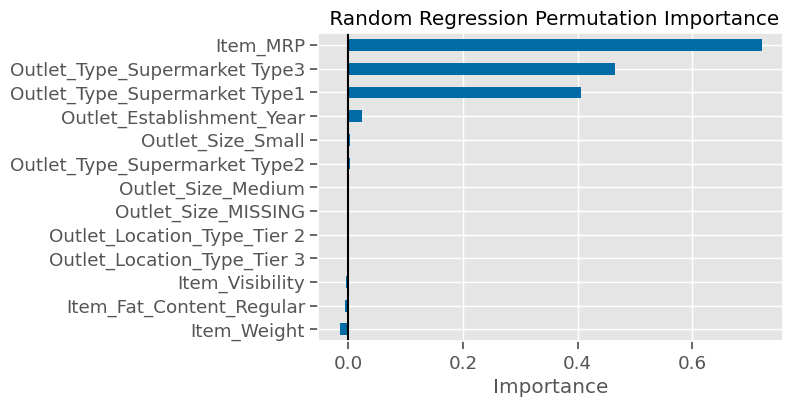

<AxesSubplot: title={'center': ' Random Regression Permutation Importance'}, xlabel='Importance'>

In [13]:
plot_importances(permutation_importances, sort_values=True, top_n=None, figsize=(6,4),
                     title=" Random Regression Permutation Importance", xlabel='Importance')

# LinearRegression Permutation Importance

In [14]:
l = permutation_importance(lin_model, X_test_df, y_test,n_repeats =5, random_state=SEED)
l.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [15]:
perm_importances_linreg = pd.Series(l['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
perm_importances_linreg = perm_importances_linreg.sort_values(ascending=False)
perm_importances_linreg

Item_MRP                         0.641628
Outlet_Type_Supermarket Type3    0.633832
Outlet_Type_Supermarket Type1    0.584400
Outlet_Type_Supermarket Type2    0.129286
Outlet_Location_Type_Tier 2      0.005632
Outlet_Size_Medium               0.002124
Outlet_Location_Type_Tier 3      0.000562
Outlet_Size_Small                0.000306
Outlet_Size_MISSING              0.000176
Item_Weight                     -0.000022
Outlet_Establishment_Year       -0.000079
Item_Visibility                 -0.000086
Item_Fat_Content_Regular        -0.000245
Name: permutation importance, dtype: float64

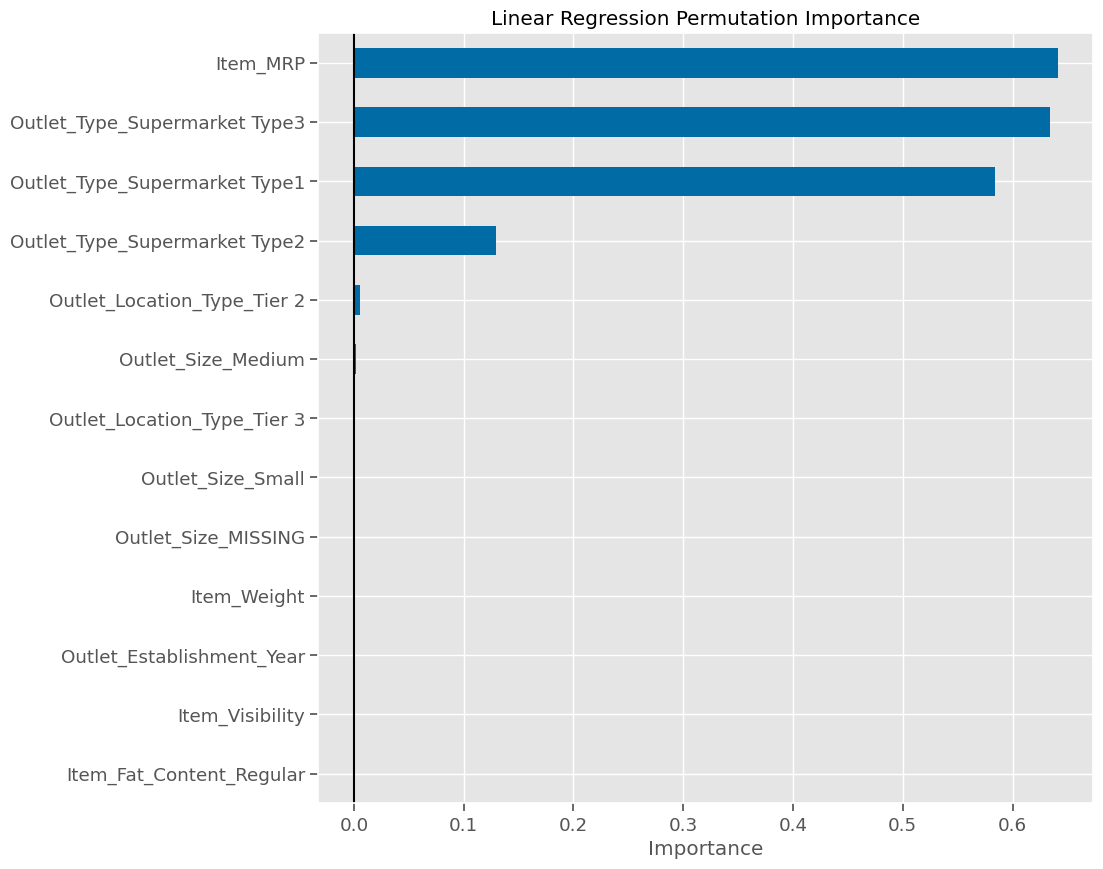

<AxesSubplot: title={'center': 'Linear Regression Permutation Importance'}, xlabel='Importance'>

In [16]:
plot_importances(perm_importances_linreg, sort_values=True, top_n=None, figsize=(10,10),
                     title="Linear Regression Permutation Importance", xlabel='Importance')

![Linear_no_item_type](https://github.com/CaillahR/Importances-and-Coefficients/assets/121994185/44b11a27-3fcc-4e31-a16b-6b72be4fbb6f)

- The Permutation Importance Feature now shows that the 3 most important features for our lin_reg model is also the same most important features as our Random Regression model. However they are not the same for our original model. Outlet_Type_Supermarket Type 3, Type 1, and Type 2 are still in the top 3 but not the others.

# SHAP

In [17]:
# Import and init shap
import shap
shap.initjs()

In [18]:
X_shap = shap.sample(X_train_df,nsamples=500,random_state=SEED)
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
3888        15.85         0.110653   36.9506                     2007.0   
2497        15.10         0.087407  221.8456                     1997.0   
7723        17.50         0.015592  184.8266                     2002.0   
8117        10.80         0.049820  243.2144                     2002.0   
7475        15.00         0.044999  140.4838                     2002.0   

      Item_Fat_Content_Regular  Outlet_Size_MISSING  Outlet_Size_Medium  \
3888                       1.0                  1.0                 0.0   
2497                       1.0                  0.0                 0.0   
7723                       0.0                  1.0                 0.0   
8117                       0.0                  1.0                 0.0   
7475                       0.0                  1.0                 0.0   

      Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
3888                0.0                          1.0   
2497                1.0                          0.0   
7723                0.0                          1.0   
8117                0.0                          1.0   
7475                0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
3888                          0.0                            1.0   
2497                          0.0                            1.0   
7723                          0.0                            1.0   
8117                          0.0                            1.0   
7475                          0.0                            1.0   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
3888                            0.0                            0.0  
2497                            0.0                            0.0  
7723                            0.0                            0.0  
8117                            0.0                            0.0  
7475                            0.0                            0.0

In [19]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

3888     759.0120
2497     663.1368
7723    2766.3990
8117    1225.0720
7475    1685.8056
          ...    
3467     506.0080
2322    2888.2404
3435    5069.4012
6561    1030.6584
7431    3691.1952
Name: Item_Outlet_Sales, Length: 500, dtype: float64

In [20]:
rf_explainer = shap.Explainer(reg_model)

## Get shap values from the explainer
rf_shap_values = rf_explainer(X_shap)

In [21]:
rf_shap_values.shape

(500, 13)

In [22]:
rf_shap_values[0]

.values =
array([ 1.13486348e+01, -1.89860831e-01, -1.66541792e+03,  5.69559051e+01,
        4.48219798e+00, -7.94365875e+00, -2.19305566e+01,  1.28518289e+00,
       -1.60051513e+00, -9.98289727e-01,  1.99411296e+02, -2.14589567e+01,
       -9.26127484e+01])

.base_values =
array([2211.75314339])

.data =
array([1.58500000e+01, 1.10653377e-01, 3.69506000e+01, 2.00700000e+03,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [23]:
## Creating an explainer for the lin_reg
linreg_explainer = shap.Explainer(lin_model, X_shap)

## get shap values for linreg
linreg_shap_values = linreg_explainer(X_shap)
linreg_shap_values.shape

(500, 13)

In [24]:
linreg_shap_values[0]

.values =
array([   -4.66322934,   -23.46540375, -1654.92440267,    -7.62115084,
          43.8444726 ,   -67.09266939,   -55.25590186,    -6.10068584,
          99.82696062,   -44.49912111,   660.81601447,  -214.89181815,
        -405.55311223])

.base_values =
2336.0058814417616

.data =
array([1.58500000e+01, 1.10653377e-01, 3.69506000e+01, 2.00700000e+03,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

Text(0.5, 1.0, 'Random Forest SHAP Summary')

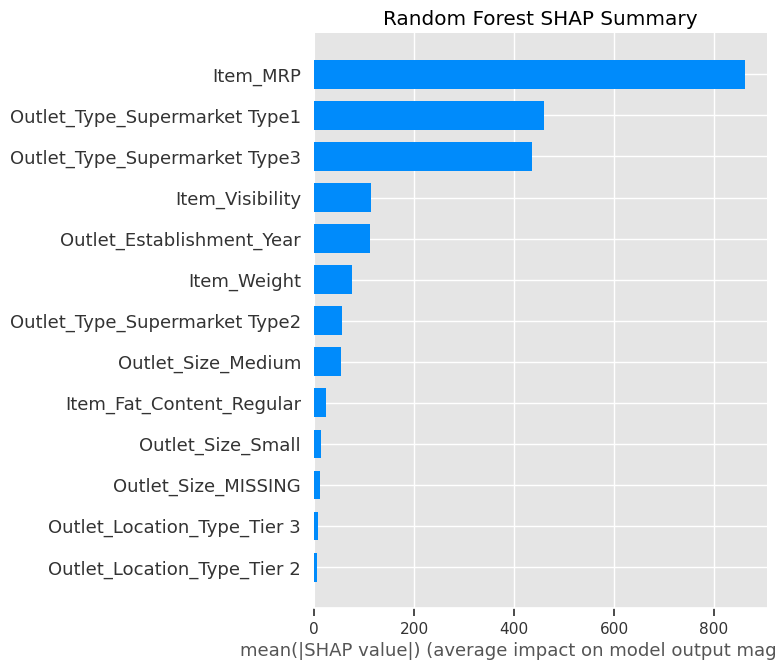

In [25]:
## creating a summary plot (bar version)
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar',
                 show=False)

plt.title('Random Forest SHAP Summary')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Random Forest SHAP Summary')

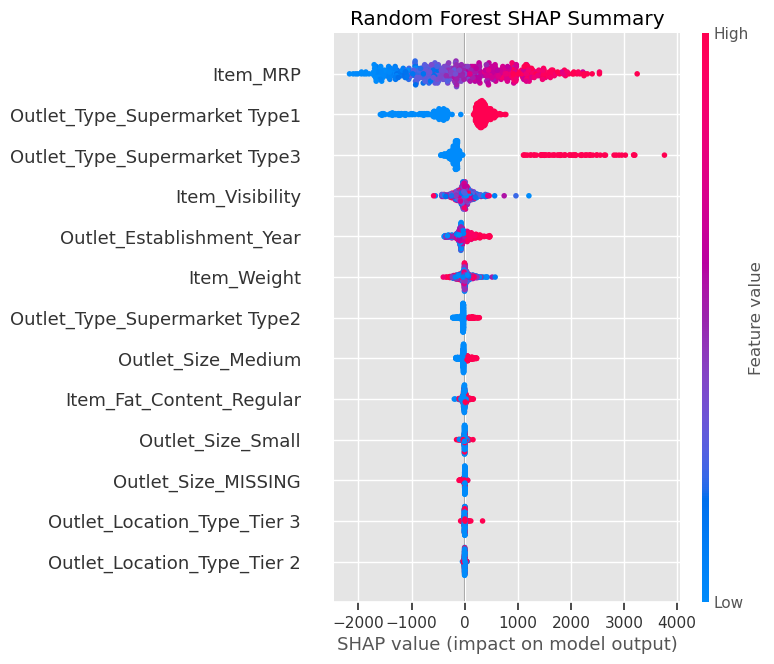

In [26]:
## creating a summary plot (bar version)
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='dot',
                 show=False)

plt.title('Random Forest SHAP Summary')

- 

Text(0.5, 1.0, 'Linear Regression SHAP Summary')

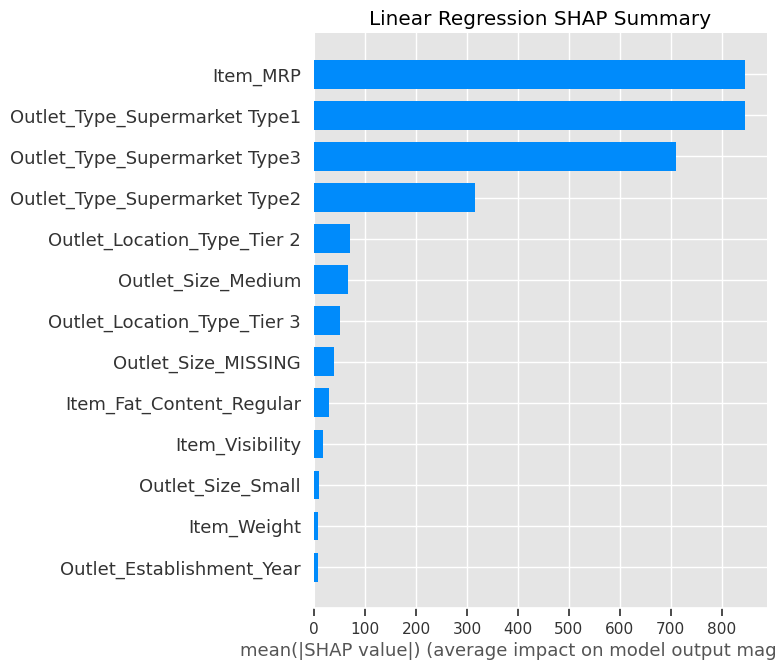

In [27]:
## creating a summary plot for Linear Regression (bar version)
shap.summary_plot(linreg_shap_values, features = X_shap, plot_type='bar',
                 show=False)

plt.title('Linear Regression SHAP Summary')

Text(0.5, 1.0, 'Linear Regression SHAP Summary')

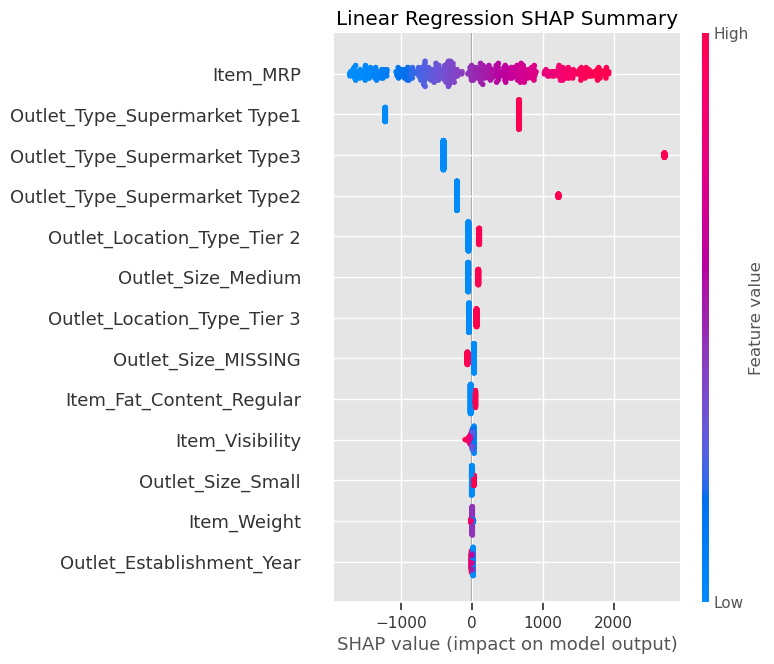

In [28]:
## creating a summary plot for Linear Regression (dot version)
shap.summary_plot(linreg_shap_values, features = X_shap, plot_type='dot',
                 show=False)

plt.title('Linear Regression SHAP Summary')

- 

# Local Explanations

In [29]:
print(X_shap.index[:5])

Int64Index([3888, 2497, 7723, 8117, 7475], dtype='int64')


In [30]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0        15.85         0.110653   36.9506                     2007.0   
1        15.10         0.087407  221.8456                     1997.0   
2        17.50         0.015592  184.8266                     2002.0   
3        10.80         0.049820  243.2144                     2002.0   
4        15.00         0.044999  140.4838                     2002.0   

   Item_Fat_Content_Regular  Outlet_Size_MISSING  Outlet_Size_Medium  \
0                       1.0                  1.0                 0.0   
1                       1.0                  0.0                 0.0   
2                       0.0                  1.0                 0.0   
3                       0.0                  1.0                 0.0   
4                       0.0                  1.0                 0.0   

   Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
0                0.0                          1.0   
1                1.0                          0.0   
2                0.0                          1.0   
3                0.0                          1.0   
4                0.0                          1.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
0                          0.0                            1.0   
1                          0.0                            1.0   
2                          0.0                            1.0   
3                          0.0                            1.0   
4                          0.0                            1.0   

   Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
0                            0.0                            0.0  
1                            0.0                            0.0  
2                            0.0                            0.0  
3                            0.0                            0.0  
4                            0.0                            0.0

In [31]:

# Choosing the the max/range of supermarkets/grocery stores' Item_MRP because this will give a 
#great idea of what the predicted sales price is
X_shap_local['Item_MRP'].describe()

count    500.000000
mean     144.852064
std       63.551718
min       32.055800
25%       98.206150
50%      143.612800
75%      190.685900
max      265.222600
Name: Item_MRP, dtype: float64

In [32]:
idx_min_MRP = X_shap_local['Item_MRP'].idxmin()
idx_min_MRP

6

In [33]:
## saving the index of the highest MRP
idx_max_MRP = X_shap_local['Item_MRP'].idxmax()
idx_max_MRP


171

In [34]:
pd.set_option('display.float_format', lambda x: f"{x:.2f}")

In [35]:
X_shap_local.iloc[idx_min_MRP]

Item_Weight                       16.10
Item_Visibility                    0.16
Item_MRP                          32.06
Outlet_Establishment_Year       2004.00
Item_Fat_Content_Regular           1.00
Outlet_Size_MISSING                0.00
Outlet_Size_Medium                 0.00
Outlet_Size_Small                  1.00
Outlet_Location_Type_Tier 2        1.00
Outlet_Location_Type_Tier 3        0.00
Outlet_Type_Supermarket Type1      1.00
Outlet_Type_Supermarket Type2      0.00
Outlet_Type_Supermarket Type3      0.00
Name: 6, dtype: float64

In [36]:
# checking the feature values for selected example
X_shap_local.iloc[idx_max_MRP]

Item_Weight                       10.00
Item_Visibility                    0.03
Item_MRP                         265.22
Outlet_Establishment_Year       2002.00
Item_Fat_Content_Regular           0.00
Outlet_Size_MISSING                1.00
Outlet_Size_Medium                 0.00
Outlet_Size_Small                  0.00
Outlet_Location_Type_Tier 2        1.00
Outlet_Location_Type_Tier 3        0.00
Outlet_Type_Supermarket Type1      1.00
Outlet_Type_Supermarket Type2      0.00
Outlet_Type_Supermarket Type3      0.00
Name: 171, dtype: float64

In [37]:
## what was the actual sales price?
y_shap_local.iloc[idx_max_MRP]

5815.0972

In [38]:
y_shap_local.iloc[idx_min_MRP]

1018.674

# Shap Force Plots

## Force Plot - Linear Reg explanation

In [39]:
## plotting example force plot for max Item_MRP (from linreg)
shap.force_plot(linreg_explainer.expected_value, 
                shap_values=linreg_shap_values[idx_max_MRP].values,
               features=X_shap_local.iloc[idx_max_MRP])

- The baseline for both of our forceplots is 2,336

- The red features are pushing heavily towards predicting lower sales with this store. With Outlet_Location_Type_Tier = 1, meaning it is located in Tier 2, Outlet Supermarket Type 1 = yes, and (the biggest feature)Item_MRP at 265.2 rupies.

- A bold value at the intersection of the red and blue is the final SHAP value for the observation.
- Here the SHAP value is 4,227.53

In [40]:
## plotting example force plot for max Item_MRP (from linreg)
shap.force_plot(linreg_explainer.expected_value, 
                shap_values=linreg_shap_values[idx_min_MRP].values,
               features=X_shap_local.iloc[idx_min_MRP])

- The baseline for both of our forceplots is 2,336

- The blue features are pushing heavily towards predicting higher sales with this store. With Item_MRP = 32.06, Outlet Supermarket Type 3 and 2 = no, and (the biggest feature)Item_MRP at 32.06 rupies.

- A bold value at the intersection of the red and blue is the final SHAP value for the observation.
- Here the SHAP value is 680.65.

## Force Plot - Random Reg explanation

In [41]:
## plotting example force plot for most Item.MRP's (from rf)
shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_values[idx_max_MRP].values,
               features = X_shap_local.iloc[idx_max_MRP])

- The baseline for both of our forceplots is 2,212

- The red features are pushing heavily towards predicting lower sales with this store. With Item_Visibility = 0.026, Outlet Supermarket Type 1, and (the biggest feature)Item_MRP at 265.2 rupies.

- A bold value at the intersection of the red and blue is the final SHAP value for the observation.
- Here the SHAP value is 5,217.01


In [42]:
shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_values[idx_min_MRP].values,
               features = X_shap_local.iloc[idx_min_MRP])

- The blue features are pushing heavily towards predicting higher sales with this store. Features showing Outlet Supermarket Type 3 = No and Item_MRP at 32.06 rupies.

- Here the SHAP value is 788.11

# LIME

In [43]:
from lime.lime_tabular import LimeTabularExplainer

## Creating a lime explainer with X_shap_local with regression as the mode
## Don't need to show it the model yet.
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names = X_shap_local.columns,
                                      mode='regression')

lime_explainer

In [44]:
import os
os.makedirs("Images/", exist_ok=True)


## Random Regression

In [51]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_max_MRP],
                                      reg_model.predict)


exp.show_in_notebook()
random_reg_LIME1 = plt.gcf()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

- This store from our low-MRP group had a very high probability of high sales.
- While this store has an even number of features that were associated with positive sale predictions:
    - Item_MRP = >190.69 rupies
    - Outlet_Type_Supermarket Type 1 = 1 (yes)
    - Item_Visibility = <= 0.03

- Three of the top 5 most impactful features were associated with negative sales predictions:
    - Outlet_Type_Supermarket 3 = 0 (no)
    - Outlet_Size_Medium = 0 (no)
    - Outlet_Type_Supermarket Type 2 = 0 (no)
    
- Becasue this store is not a Type 2 or 3, and not a size medium store this will affect the sales negatively.
- Predicted sales: 5217.01 rupies

In [46]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_min_MRP],
                                      reg_model.predict)
exp.show_in_notebook()
random_reg_LIME2 = plt.gcf()
random_reg_LIME2.savefig('Images/random_reg_LIME2')

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


<Figure size 640x480 with 0 Axes>

- This store from our low-MRP group had a very high probability of low sales.
- While this store has an even number of features that were associated with positive sale predictions:
    - Outlet_Type_Supermarket 1 = 1 (yes)
    - Outlet_Size_Small = 1 (yes), also >0
    - Item_Fat_Content_Regular = 1 (yes), also >0
    - Outlet_Size_MISSING = 0 (no), known size
    - Outlet_Location_Type_Tier 2 = 1 (yes)

- Four of the top 5 most impactful features were associated with negative sales predictions:
    - Outlet_Type_Supermarket 3 = 0 (no)
    - Item_MRP = 32.06 rupies
    - Outlet_Type_Supermarket 2 = 0 (no)
    - Outlet_Size_Medium = 0 (no)
    
- Becasue this store is in a Tier 3 location, not a medium size location, no Type 2 and 3 supermarket, and a low Item_MRP this will affect the sales negatively.
- Predicted sales: 788.11 rupies

## Linear Regression

In [47]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_max_MRP],
                                      lin_model.predict)
exp.show_in_notebook()
Linear_reg_LIME1 = plt.gcf()
Linear_reg_LIME1.savefig('Images/Linear_reg_LIME1')

X does not have valid feature names, but LinearRegression was fitted with feature names


<Figure size 640x480 with 0 Axes>

- This store from our high-MRP group had a high probability of sales.
- While this store has a few number of features that were associated with positive sale predictions:
    - Outlet_Type_Supermarket Type 1 = 1 (yes)
    - Item_MRP = >190.69
    - Outlet_Location_Type_Tier 2 = 1 (yes)

- Two of the top 5 most impactful features were associated with negative sales predictions:
    - Outlet_Type_Supermarket Type 3 = 0 (no)
    - Outlet_Type_Supermarket Type 2 = 0 (no)
    
- Because this store is not a Type 3 or Type 2 supermarket  this will affect the sales negatively.
- Predicted sales: 4227.53 rupies

In [49]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_min_MRP],
                                      lin_model.predict)
exp.show_in_notebook()
linear_reg_LIME2 = plt.gcf()
linear_reg_LIME2.savefig('Images/Linear_reg_LIME2')

X does not have valid feature names, but LinearRegression was fitted with feature names


<Figure size 640x480 with 0 Axes>

- This store from our high-MRP group had a high probability of very low sales.
- While this store has a few number of features that were associated with positive sale predictions:
    - Outlet_Type_Supermarket Type 1 = 1 (yes)
    - Outlet_Location_Type_Tier 2 = 1 (yes)
    - Item_Fat_Content_Regular = 1 (yes)
    - Outlet_Size_MISSING = 0 (no)
    
- Three of the top 5 most impactful features were associated with negative sales predictions:
    - Outlet_Type_Supermarket Type 3 = 0 (no)
    - Item_MRP = <= 98.21
    - Outlet_Type_Supermarket Type 2 = 0 (no)
    
- Because this store is not a Type 3 or Type 2 supermarket and has a low Item_MRP of 32.06 this will affect the sales negatively.
- Predicted sales: 680.65 rupies